In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Why EP-ABC can produce too narrow posteriors

When you use EP-ABC for inference you may notice that your posterior distributions appear suspiciously narrow, i.e., you may not belief the certainty indicated by EP-ABC inference. Your suspicions can be correct: The posteriors inferred by EP-ABC sometimes tend to be too narrow. The fault lies within the recursive sampling process used in EP-ABC: The main mechanism is to maintain an estimate of the posterior distribution from which you sample and then re-estimate the posterior distribution based on a subset of the samples compatible with a data point. If the distribution from which you sample has some [sampling error](https://en.wikipedia.org/wiki/Sampling_error), your next estimate of that distribution will deviate even more from the underlying distribution, especially, if the sampling error consistently deviates in one direction. This is exactly what can happen in individual runs of EP-ABC.

In the following, I will demonstrate drifting distribution estimates by recursively sampling from a Gaussian. Ideally, the estimated mean and standard deviation would remain stable, but sampling error lets them drift. The question, therefore, is how strong the drift is and whether it has a trend.

## Sampling theory
It is known, but rarely appreciated, that the square root of an unbiased estimate of [variance](https://en.wikipedia.org/wiki/Variance) consistently underestimates the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation). Because we use standard deviations when sampling from a Gaussian (also in EP-ABC), recursively sampling from a Gaussian will shrink its standard deviation, even though we may have no bias in estimating the variance of the distribution. Actually, it's not so hard to compute an [unbiased estimate of the standard deviation](https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation), at least approximately: Instead of dividing by $N-1$, as in the unbiased estimate of variance, we only have to divide by $N-1.5$. I have implemented this in EP-ABC to reduce the shrinking of posteriors. Below you can see for yourself what effect this has.

## Some plotting functions
I here define some plotting functions used below.

In [2]:
def plot_mean_with_std(mean, std, std_mult=2, xvals=None, ax=None):
    if xvals is None:
        xvals = np.arange(mean.shape[0])
    if ax is None:
        ax = plt.axes()
        
    ax.plot(mean, 'k', lw=3)
    ax.fill_between(xvals, mean + std_mult*std, mean - std_mult*std, 
                    edgecolor='k', facecolor='0.7')

def plot_single_trajectory(means, stds, rep=None):
    if rep is None:
        rep = np.random.randint(means.shape[0])
        
    xvals = np.arange(means.shape[1])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    ax1.set_title('repetition %d' % rep)
    plot_mean_with_std(means[rep, :], stds[rep, :], xvals=xvals, ax=ax1)
    
    ax2.set_ylabel('mean')
    ax2.plot(xvals, means[rep, :], 'k', lw=3, label='mean')
    ax3.set_ylabel('std')
    ax3.plot(xvals, stds[rep, :], 'k', lw=1, label='std')
    
    diff = means[rep, :] - means[rep, 0]
    print('largest deviation from initial mean: %6.1f%% (of initial std)' 
          % (diff[np.abs(diff).argmax()] / stds[rep, 0] * 100, ) )
    diff = stds[rep, :] - stds[rep, 0]
    print('largest deviation from initial  std: %6.1f%%' 
          % (diff[np.abs(diff).argmax()] / stds[rep, 0] * 100, ) )
    
def plot_distribution_drift(means, stds):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
    ax1.set_title('average drift of mean (+- 2*std)')
    plot_mean_with_std(means.mean(axis=0), means.std(axis=0), ax=ax1)
    ax2.set_title('average drift of std (+- 2*std)')
    plot_mean_with_std(stds.mean(axis=0), stds.std(axis=0), ax=ax2)
    

## Recursive Sampling of a Gaussian

The following cell repeatedly runs a recursive sampling process and plots the average drifts of mean and standard deviation across the repetitions.

after 200 steps with 500 samples:
difference in mean mean:   15.9% (of initial std)
difference in mean  std:    5.3%


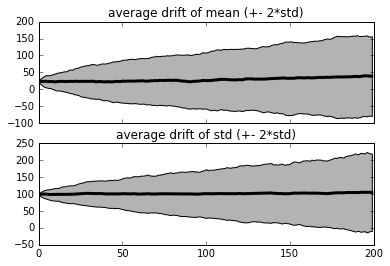

In [3]:
# number of recursive steps
nsteps = 200
# number of samples drawn from distribution
nsamples = 500
# number of repetitions of recursive sampling
nrep = 100

# initial mean
mu = 23
# initial standard deviation
sigma = 100

# degrees of freedom determining the divisor for
# the estimation of standard deviation (1.5~unbiased)
ddof = 1.5

means = np.full((nrep, nsteps), np.nan)
means[:, 0] = mu
stds = np.full((nrep, nsteps), np.nan)
stds[:, 0] = sigma

for r in range(nrep):
    for s in range(1, nsteps):
        S = np.random.normal(means[r, s-1], stds[r, s-1], nsamples)
        means[r, s] = S.mean()
        stds[r, s] = S.std(ddof=ddof)
        
plot_distribution_drift(means, stds)
print('after %d steps with %d samples:'  % (nsteps, nsamples))
print('difference in mean mean: %6.1f%% (of initial std)' % (
        (means[:, -1].mean() - mu) / sigma * 100, ))
print('difference in mean  std: %6.1f%%' % ((stds[:, -1].mean() - sigma) / 
                                            sigma * 100, ))

The generated plots should have a relatively flat, thick, black line in the middle which suggests that mean and standard deviation did not change much when averaged across repetitions. The shading, representing the area of double standard deviation across repetitions, however, should become wider as more recursive sampling steps are taken, indicating that in some repetitions there was a considerable drift of the distribution (see below for plots of individual trajectories).

You may now want to see how these curves change, when you manipulate the number of samples, or degrees of freedom (ddof) used to estimate standard deviations from samples. Increasing the number of samples is generally good and leads to a reduction of mean drift and a narrowing of the shading, meaning that also the drift in individual repetitions of recursive sampling is small. Setting `ddof=0`, which is the standard setting of numpy (!), leads to severe shrinkage of the sampled distribution.

## Individual recursive sampling trajectories
To get a feeling for the variability of recursive sampling trajectories across repetitions the following cell will plot a single (random) trajectory computed above.

largest deviation from initial mean:   54.6% (of initial std)
largest deviation from initial  std:   26.2%


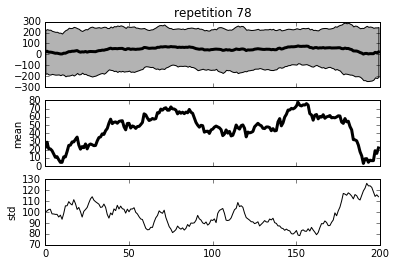

In [4]:
plot_single_trajectory(means, stds)

## Conclusion
It is remarkable how strongly mean and standard deviation of the sampled Gaussian can drift in a single run of the recursive sampling process. Their largest deviations from their initial values often exceed 50% of the initial standard deviation and the mean moves more than the standard deviation. This may look like a severe problem for EP-ABC at first, but note that the posterior in EP-ABC cannot freely drift like here. It is strongly constrained by the data. These constraints particularly prevent the mean from drifting and prevent the standard deviation from increasing. However, the constraints are less efficient in preventing shrinkage of the posterior, if the data is explained well enough by a subregion covered by the true posterior. For example, if your data is explained equally well by either of two sets of parameter values, shrinkage of the posterior induced by random drifts due to sampling error may force the EP-ABC posterior to cover only one set of parameter values, instead of both of them. It is possible to identify these situations by repeating the inference with EP-ABC and checking the consistency of the inferred posteriors. Sampling errors and the resulting drift of posteriors can also be prevented by setting the minimum number of accepted samples in EP-ABC (`minacc`) to a high value, e.g., 500 or 1000.